In [51]:
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, GRU, Attention

# Load data from JSON file
with open("data.json") as f:
    data = json.load(f)

# Extract features and target
X = np.column_stack((data["o"], data["h"], data["l"], data["c"], data["v"]))
y = np.array(data["c"])

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape data for LSTM input (samples, timesteps, features)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.7, random_state=42
)

# Build the model
model = Sequential()
model.add(
    Bidirectional(
        GRU(
            units=128,
            return_sequences=True,
            input_shape=(X_scaled.shape[1], X_scaled.shape[2]),
        )
    )
)
model.add(Dropout(0.2))
model.add(
    Bidirectional(
        GRU(units=128),
    )
)
model.add(Dropout(0.2)),
model.add(Dense(32, kernel_initializer="uniform", activation="relu"))
model.add(Dense(1, kernel_initializer="uniform", activation="linear"))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model using train data
model.fit(X_train, y_train, epochs=50, batch_size=4096, verbose=1)

# Evaluate the model on test data
loss = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", loss)

# Predict tomorrow's value
last_data_point = X_scaled[-1].reshape(1, X_scaled.shape[1], 1)
predicted_values = []

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.2038
Epoch 2/50
1/1 [==============================] - 0s 76ms/step - loss: 0.1956
Epoch 3/50
1/1 [==============================] - 0s 97ms/step - loss: 0.1875
Epoch 4/50
1/1 [==============================] - 0s 75ms/step - loss: 0.1786
Epoch 5/50
1/1 [==============================] - 0s 64ms/step - loss: 0.1682
Epoch 6/50
1/1 [==============================] - 0s 75ms/step - loss: 0.1558
Epoch 7/50
1/1 [==============================] - 0s 116ms/step - loss: 0.1409
Epoch 8/50
1/1 [==============================] - 0s 66ms/step - loss: 0.1231
Epoch 9/50
1/1 [==============================] - 0s 57ms/step - loss: 0.1022
Epoch 10/50
1/1 [==============================] - 0s 60ms/step - loss: 0.0780
Epoch 11/50
1/1 [==============================] - 0s 64ms/step - loss: 0.0521
Epoch 12/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0273
Epoch 13/50
1/1 [==============================] - 0s 63ms/ste

In [52]:
for _ in range(365):
    # Predict next day's value
    predicted_value_scaled = model.predict(last_data_point)
    predicted_value = scaler_y.inverse_transform(predicted_value_scaled)
    predicted_values.append(predicted_value.flatten()[0])

    # Append the predicted value to the end of the data
    last_data_point = np.concatenate(
        [last_data_point[:, 1:], predicted_value_scaled.reshape(1, 1, 1)], axis=1
    )

print("Predicted Close Prices for Next 7 Days:", predicted_values)

1/1 [==============================] - 0s 16ms/step
Predicted Close Prices for Next 7 Days: [1319.2556, 1324.4188, 1333.84, 1348.3485, 1368.4823, 1429.1884, 1446.9468, 1467.5626, 1490.1199, 1513.6113, 1536.861, 1553.9344, 1570.8368, 1586.9774, 1601.9158, 1615.3677, 1627.2384, 1638.2421, 1648.278, 1657.3348, 1665.4684, 1672.7814, 1679.394, 1685.3392, 1690.6694, 1695.4447, 1699.724, 1703.5576, 1706.9857, 1710.0487, 1712.7848, 1715.2275, 1717.4077, 1719.352, 1721.0854, 1722.6304, 1724.007, 1725.2333, 1726.3251, 1727.2972, 1728.1626, 1728.9329, 1729.6183, 1730.2279, 1730.7704, 1731.2529, 1731.6821, 1732.064, 1732.4033, 1732.7051, 1732.9736, 1733.2123, 1733.4243, 1733.6132, 1733.7808, 1733.9297, 1734.0624, 1734.18, 1734.285, 1734.3779, 1734.4607, 1734.5343, 1734.5997, 1734.6577, 1734.7094, 1734.7554, 1734.796, 1734.8325, 1734.8646, 1734.8933, 1734.9187, 1734.9415, 1734.9615, 1734.9795, 1734.9952, 1735.0093, 1735.0219, 1735.033, 1735.0428, 1735.0516, 1735.0594, 1735.0665, 1735.0728, 1735.078

In [53]:
# Convert predicted values to original scale
predicted_values_original = scaler_y.inverse_transform(predicted_value_scaled).flatten()

# Convert actual values to original scale
actual_values_original = scaler_y.inverse_transform(y_test).flatten()

# Calculate the absolute percentage error
absolute_percentage_error = (
    np.abs(predicted_values_original - actual_values_original) / actual_values_original
)

# Define a threshold for considering a prediction as correct
threshold = 0.5  # For example, considering predictions within 5% of the actual value as correct

# Count correct and incorrect predictions
correct_predictions = np.sum(absolute_percentage_error <= threshold)
incorrect_predictions = np.sum(absolute_percentage_error > threshold)

# Calculate accuracy
total_predictions = len(absolute_percentage_error)
accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)

Accuracy: 0.09427860696517414


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions on test data
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_inverse = scaler_y.inverse_transform(y_test)

# Calculate RMSE
rmse = mean_squared_error(y_test_inverse, predictions, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAE
mae = mean_absolute_error(y_test_inverse, predictions)
print("Mean Absolute Error (MAE):", mae)

126/126 [==============================] - 1s 7ms/step
Root Mean Squared Error (RMSE): 28.283371766929566
Mean Absolute Error (MAE): 23.86846888300198


In [55]:
# model.save("vni.h5")

In [56]:
# from tensorflow.keras.models import load_model

# model = load_model("vni.h5")

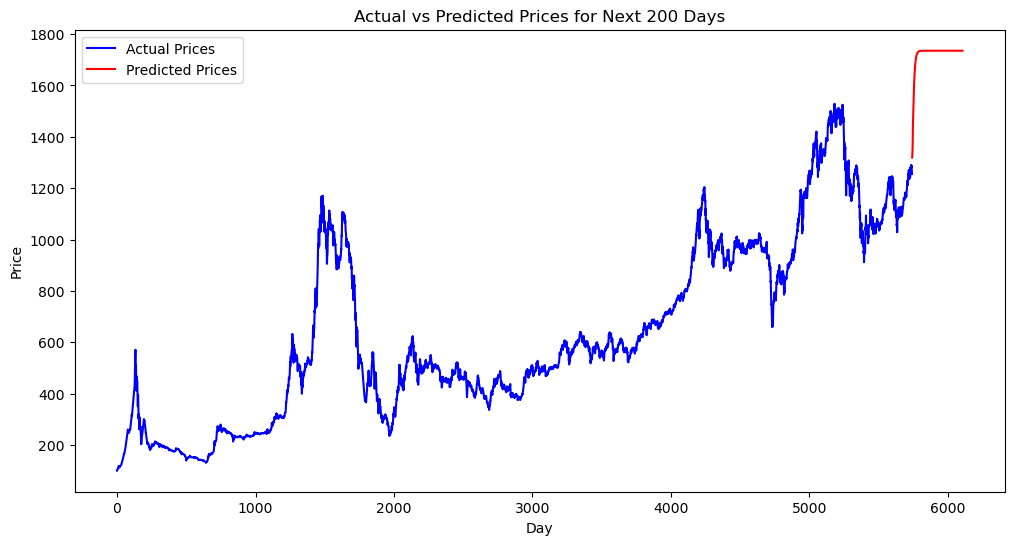

In [57]:
# Vẽ biểu đồ
from matplotlib import pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(y, label="Actual Prices", color="blue")
plt.plot(
    np.arange(len(X_scaled), len(X_scaled) + 365),
    predicted_values,
    label="Predicted Prices",
    color="red",
)
plt.title("Actual vs Predicted Prices for Next 200 Days")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()